# RQ分析

### バグ発見
* 2021/01/14 コミット者の比較を 文字列イコールで行っていたが、メールアドレスが変わる場合があるため名前だけで判断する必要がある
→ 名前のみで判断することにした（こっちの方が直感的でわかりやすい）

## AuthorDateとCommiterDate
コミットした日が AuthorDateでrebase などを行った、最終的に git に反映さえている日が CommiterDate<br>
rebase（歴史の改変）を行っているため、分析にバグが出る。よってCommiterDateを利用する

In [210]:
import os
import re
import pandas as pd
import numpy as np
from datetime import datetime
import subprocess
import matplotlib.pyplot as plt
import seaborn as sns
import hashlib

import warnings
warnings.filterwarnings('ignore')

# 画像出力
from IPython.display import Image

pd.options.display.float_format = '{:.1f}'.format

## 前処理で使用する関数

In [211]:
# Daterange の数値化
def daterange_to_minute(d):
    if "days," in d:
        days_time = d.split(" days, ")
        days = days_time[0]
        time = days_time[1].split(":")
        return int(days)*24*60 + int(time[0])*60 + int(time[1])
    elif "day," in d:
        days_time = d.split(" day, ")
        days = days_time[0]
        time = days_time[1].split(":")
        return int(days)*24*60 + int(time[0])*60 + int(time[1])
    elif "days" in d:
        days_time = d.split(" days ")
        days = days_time[0]
        time = days_time[1].split(":")
        return int(days)*24*60 + int(time[0])*60 + int(time[1])
    else:
        time = d.split(":")
        return int(time[0])*60 + int(time[1])

## データの読み込み

In [212]:
df = pd.read_csv('../../data/comment_classification.csv', index_col=0)


## DateRange の 数値化
df['SATD追加から削除までの日数'] = df['SATD追加から削除までの日数'].apply(lambda dt: daterange_to_minute(dt))
df['firstCommitからSATD追加までの日数'] = df['firstCommitからSATD追加までの日数'].apply(lambda dt: daterange_to_minute(dt))

df.head()

,【削除手法分類】\nA. コードが変化していない\n A1. SATDコメントのみの削除\n A2. ただしコメント（説明）のみの追加を含む\nB. 内部で本質的に解決した\n B1. コメントに記載された方針や方法で解決\n B2. コメントに記載された方針や方法とは別の方法で解決\n B3. コメントに方針や方法が記載されていないが、何らかの方法で解決\nC. 負債とは別の箇所の変更で負債自体がなくなった\nD. 外部で本質的に解決した\nE. 解決していない\nF. SATDではない,contributors\nSATD削除時の、対象ファイルにおけるそれまでのコントリビューターの数,分析コードによるcontributors,最新ファイル名,削除時 git,追加コミットAuthor,削除コミット Author,SATD コミット日,SATD 削除コミット日,ファイル 作成コミット日,ファイル削除コミット日,firstCommitからSATD追加までの日数,SATD追加から削除までの日数
313,B2,4,6,1.31/apache/Dockerfile,https://github.com/wikimedia/mediawiki-docker/...,Gabriel Wicke <gwicke@wikimedia.org>,David Barratt <dbarratt@wikimedia.org>,2015/12/19 10:41,2017/08/05 2:00,2015/08/13 14:16,NaN,184105,856279
178,D,1,2,3.5.8/Dockerfile,https://github.com/31z4/zookeeper-docker/commi...,Duncan Schulze <duncan.schulze@sonian.net>,Duncan Schulze <dschulze@barracuda.com>,2017/10/24 14:12,2018/06/01 0:36,2017/10/24 14:12,NaN,0,315984
255,D,1,1,rstudio/testing/Dockerfile,https://github.com/rocker-org/rocker/commit/16...,Carl Boettiger <cboettig@gmail.com>,Carl Boettiger <cboettig@gmail.com>,2016/12/22 3:57,2016/12/23 0:55,2016/11/12 15:45,NaN,56892,1258
121,D,78,62,components/engine/Dockerfile,https://github.com/docker/docker-ce/commit/7fe...,Tibor Vass <tibor@docker.com>,Antonio Murdaca <runcom@redhat.com>,2016/04/16 10:00,2016/05/25 18:58,2013/7/9 13:30,NaN,1457070,56698
452,B3,4,4,12/jdk/oracle/Dockerfile,https://github.com/docker-library/openjdk/comm...,Tianon Gravi <admwiggin@gmail.com>,Emil Koutanov <ekoutanov@gmail.com>,2018/10/02 4:16,2019/5/25 6:28,2018/10/02 4:16,2019/09/18 8:59,0,338532


In [213]:
df.columns = [
    "class",
    "github-contributors",
    "contributors",
    "filename",
    "git",
    "add-author",
    "delete-author",
    "commit-date",
    "delete-date",
    "file-create-date",
    "file-delete-date",
    "daterange-createfile-to-addsatd",
    "daterange-addsatd-to-deletesatd"
]

### giturl: 手動でコントリビュータを入力しよう。（ファイル名で辿れないものがあったためデバッグ時間の都合上）

## 前処理

In [214]:
## コミッター判別を行うときに メールアドレスが変わっている例があったためメールアドレスを削除する

df["add-author"] = df["add-author"].apply(lambda author_email: author_email.split("<")[0])
df["delete-author"] = df["delete-author"].apply(lambda author_email: author_email.split("<")[0])

## SATDの解決ではないものを削除

#### 削除手法分類
- A. コードが変化していない
    - A1. SATDコメントのみの削除
    - A2. ただしコメント（説明）のみの追加を含む
- B. 内部で本質的に解決した
    - B1. コメントに記載された方針や方法で解決
    - B2. コメントに記載された方針や方法とは別の方法で解決
    - B3. コメントに方針や方法が記載されていないが、何らかの方法で解決
- C. 負債とは別の箇所の変更で負債自体がなくなった
- D. 外部で本質的に解決した
- E. 解決していない
- F. SATDではない

In [215]:
df = df[~df["class"].isin(["E", "F"])]
df

,class,github-contributors,contributors,filename,git,add-author,delete-author,commit-date,delete-date,file-create-date,file-delete-date,daterange-createfile-to-addsatd,daterange-addsatd-to-deletesatd
313,B2,4,6,1.31/apache/Dockerfile,https://github.com/wikimedia/mediawiki-docker/...,Gabriel Wicke,David Barratt,2015/12/19 10:41,2017/08/05 2:00,2015/08/13 14:16,NaN,184105,856279
178,D,1,2,3.5.8/Dockerfile,https://github.com/31z4/zookeeper-docker/commi...,Duncan Schulze,Duncan Schulze,2017/10/24 14:12,2018/06/01 0:36,2017/10/24 14:12,NaN,0,315984
255,D,1,1,rstudio/testing/Dockerfile,https://github.com/rocker-org/rocker/commit/16...,Carl Boettiger,Carl Boettiger,2016/12/22 3:57,2016/12/23 0:55,2016/11/12 15:45,NaN,56892,1258
121,D,78,62,components/engine/Dockerfile,https://github.com/docker/docker-ce/commit/7fe...,Tibor Vass,Antonio Murdaca,2016/04/16 10:00,2016/05/25 18:58,2013/7/9 13:30,NaN,1457070,56698
452,B3,4,4,12/jdk/oracle/Dockerfile,https://github.com/docker-library/openjdk/comm...,Tianon Gravi,Emil Koutanov,2018/10/02 4:16,2019/5/25 6:28,2018/10/02 4:16,2019/09/18 8:59,0,338532
13,B1,2,2,3.7/ubuntu/Dockerfile,https://github.com/docker-library/rabbitmq/com...,Gerhard Lazu,Joe Ferguson,2019/01/15 18:47,2019/01/25 7:45,2019/01/15 18:45,2020/08/19 2:24,2,13738
138,D,106,90,components/engine/Dockerfile,https://github.com/docker/docker-ce/commit/389...,Vincent Demeester,Kir Kolyshkin,2018/02/28 17:04,2018/09/07 7:24,2013/07/09 13:30,NaN,2441014,274460
369,D,1,2,sros/kinetic/Dockerfile,https://github.com/osrf/docker_images/commit/b...,ruffsl,ruffsl,2016/08/12 2:31,2018/01/04 8:43,2016/08/12 2:31,NaN,0,734772
135,A1,109,93,components/engine/Dockerfile,https://github.com/docker/docker-ce/commit/ccd...,Brian Goff,Brian Goff,2018/02/26 17:10,2019/04/18 3:11,2013/07/09 13:30,NaN,2438140,598201
8,B1,1,1,3.7/ubuntu/Dockerfile,https://github.com/docker-library/rabbitmq/com...,Gerhard Lazu,Gerhard Lazu,2019/01/15 18:45,2019/1/15 18:47,2019/01/15 18:45,2020/08/19 2:24,0,2


# RQ1（仮）どれくらいのSATDが解決されているか？

#### python 0-analysisFunc.py
* from 3-pastfiles  全Dockerfile の全プロジェクト全リビジョンでの変更されたコミット数<br>
→85269
* リビジョン統合前全コメント数<br>
→496785
* UniqueComments from 4-rowComments (全プロジェクト全リビジョンでのユニークコメント検出)<br>
→4514
* UniqueComments from 5-SATDComments (全プロジェクト全リビジョンでのSATD検出)<br>
→12313
* SATD from 8-result.csv (全プロジェクト全リビジョンでのSATD検出(Fileが異なる物は異なるものとしてカウント -> file ごとにコメントマージ))<br>
→440
* UniqueSATD from 8-result.csv (全プロジェクト全リビジョンでのユニークSATD検出)<br>
→125
* 削除されたユニークSATD (ファイル削除・コメント削除)<br>
→96
* 削除されたユニークSATD (ファイル削除)<br>
→42
* 削除されたユニークSATD (コメント削除)<br>
→57
* 削除されていないユニークSATD<br>
→46

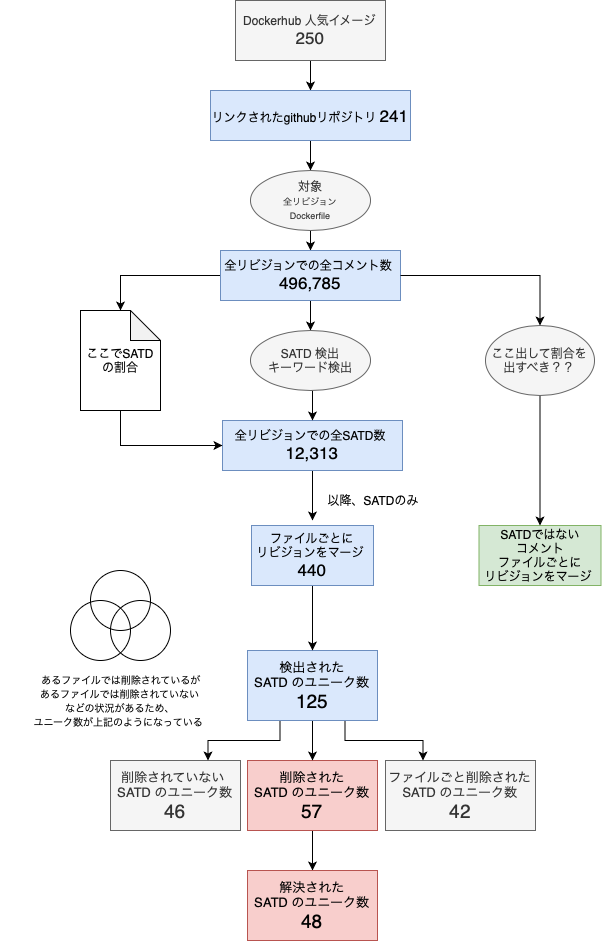

In [216]:
Image("./SATD検出結果.png")

In [217]:
print(f"対象となる解決されたSATDの件数（一意）: {len(df)}件")

対象となる解決されたSATDの件数（一意）: 48件


In [218]:
print(f"検出されたSATDのうち解決されているもの: {48/125:.2%}")

検出されたSATDのうち解決されているもの: 38.40%


# RQ2（仮）誰がSATDを除去するのか？

#### それぞれのプロジェクトでのコミッターの数

In [219]:
df[["contributors"]].describe()

,contributors
count,48.0
mean,13.0
std,26.2
min,1.0
25%,1.0
50%,2.5
75%,6.2
max,93.0


In [220]:
df_same_commiter = df[df["add-author"] == df["delete-author"]]
print(f"追加者と削除者が同一：{len(df_same_commiter)} 割合：{len(df_same_commiter)/len(df):.2%}")

追加者と削除者が同一：33 割合：68.75%


#### 追加者と削除者が同一のものについて コントリビューターの数

In [221]:
df_same_commiter[["contributors"]].describe()

,contributors
count,33.0
mean,6.8
std,17.8
min,1.0
25%,1.0
50%,1.0
75%,3.0
max,93.0


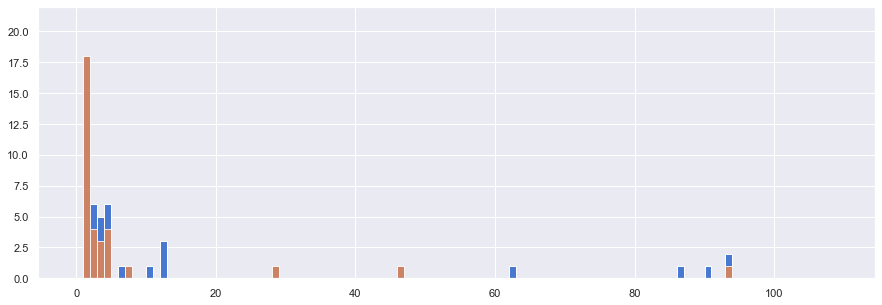

In [222]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1,1,1)

# ax.hist([df["contributors"], df_same_commiter["contributors"]], bins=range(0, 110));

df["contributors"].hist(bins=range(0, 110));
df_same_commiter["contributors"].hist(bins=range(0, 110), alpha=0.8);

plt.ylim(0, 22);

# RQ3（仮）どれくらいの期間でSATDが除去されるのか？

In [223]:
# 時間変換（hour, day)
df["delete_terms_hour"] = df["daterange-addsatd-to-deletesatd"].apply(lambda m: m/60)
df["delete_terms_day"] = df["daterange-addsatd-to-deletesatd"].apply(lambda m: m//60/24)

In [224]:
df[["delete_terms_hour"]].describe()

,delete_terms_hour
count,48.0
mean,3993.6
std,6698.4
min,0.0
25%,32.9
50%,1607.5
75%,5286.1
max,39574.5


In [225]:
df[["delete_terms_day"]].describe()

,delete_terms_day
count,48.0
mean,166.4
std,279.1
min,0.0
25%,1.3
50%,67.0
75%,220.2
max,1648.9


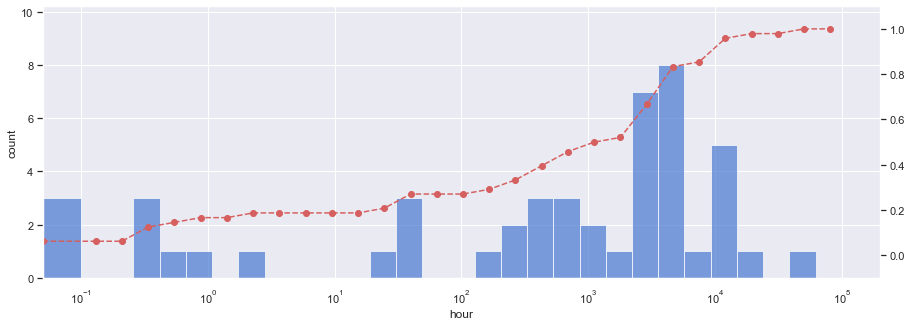

In [226]:
# % matplotlib inline

dt = df["delete_terms_hour"]
xlabel = "hour"
logmax = 5
bin_num = int((logmax+1)*10//2) if (logmax+1)*10 % 2 == 0 else int((logmax+1)*10//2) + 1

# seabornのスタイルでプロット
sns.set(style="darkgrid", palette="muted", color_codes=True)

fig, ax1 = plt.subplots(figsize=(15, 5))

# ヒストグラムプロットとビン情報の取得
# e+00 ~ e+01 で５本
n, bins, patches = ax1.hist(dt, alpha=0.7, label='Frequency', bins=np.append(0, np.logspace(-1, logmax, bin_num, base=10)))

# 第2軸用値の算出
y2 = np.add.accumulate(n) / n.sum()
x2 = np.convolve(bins, np.ones(2) / 2, mode="same")[1:]

# 第2軸のプロット
ax2 = ax1.twinx()
lines = ax2.plot(x2, y2, ls='--', color='r', marker='o',
         label='Cumulative ratio')
ax2.grid(visible=False)

ax1.set(xlabel=xlabel, ylabel='count')

fig.axes[0].set_xscale('log')
fig.axes[0].set_ylim([0, 10.2])
fig.axes[1].set_ylim([-0.1, 1.1])

plt.show()

In [227]:
graph = pd.DataFrame([n])
graph.index = ["件数"]
graph.columns = bins[:-1]

graph.iloc[:, 11:]

,11.7,18.9,30.4,48.9,78.8,126.9,204.3,329.0,529.8,853.2,1373.8,2212.2,3562.2,5736.2,9236.7,14873.5,23950.3,38566.2,62101.7
件数,0.0,1.0,3.0,0.0,0.0,1.0,2.0,3.0,3.0,2.0,1.0,7.0,8.0,1.0,5.0,1.0,0.0,1.0,0.0


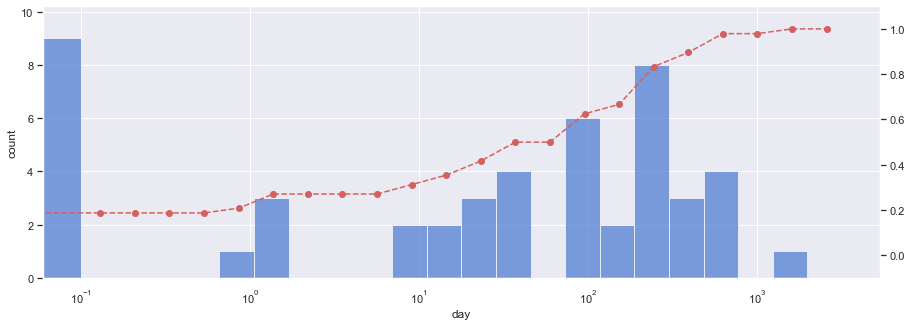

In [228]:
# % matplotlib inline

dt = df["delete_terms_day"]
xlabel = "day"
logmax = 3.5
bin_num = int((logmax+1)*10//2) if (logmax+1)*10 % 2 == 0 else int((logmax+1)*10//2) + 1

# seabornのスタイルでプロット
sns.set(style="darkgrid", palette="muted", color_codes=True)

fig, ax1 = plt.subplots(figsize=(15, 5))

# ヒストグラムプロットとビン情報の取得
# e+00 ~ e+01 で５本
n, bins, patches = ax1.hist(dt, alpha=0.7, label='Frequency', bins=np.append(0, np.logspace(-1, logmax, bin_num, base=10)))

# 第2軸用値の算出
y2 = np.add.accumulate(n) / n.sum()
x2 = np.convolve(bins, np.ones(2) / 2, mode="same")[1:]

# 第2軸のプロット
ax2 = ax1.twinx()
lines = ax2.plot(x2, y2, ls='--', color='r', marker='o',
         label='Cumulative ratio')
ax2.grid(visible=False)

ax1.set(xlabel=xlabel, ylabel='count')

fig.axes[0].set_xscale('log')
fig.axes[0].set_ylim([0, 10.2])
fig.axes[1].set_ylim([-0.1, 1.1])

plt.show()

In [229]:
graph = pd.DataFrame([n])
graph.index = ["件数"]
graph.columns = bins[:-1]

graph.iloc[:, 5:]

,0.7,1.1,1.7,2.7,4.3,6.9,11.1,17.8,28.5,45.6,73.1,117.0,187.4,300.1,480.6,769.8,1232.8,1974.5
件数,1.0,3.0,0.0,0.0,0.0,2.0,2.0,3.0,4.0,0.0,6.0,2.0,8.0,3.0,4.0,0.0,1.0,0.0


### コミッターによって違いは出るのか？

### 同一コミッター

In [230]:
df_same_commiter = df[df["add-author"] == df["delete-author"]]
df_different_commiter = df[df["add-author"] != df["delete-author"]]

In [231]:
same_commiter = df_same_commiter[['delete_terms_hour']].describe()
different_commiter = df_different_commiter[['delete_terms_hour']].describe()

commiter_df_hour = pd.concat([same_commiter, different_commiter], axis=1)
commiter_df_hour.columns = ["delete_hour:same_commiter", "delete_hour:not_delete_commiter"]
commiter_df_hour

,delete_hour:same_commiter,delete_hour:not_delete_commiter
count,33.0,15.0
mean,3808.7,4400.5
std,7516.4,4608.6
min,0.0,229.0
25%,2.8,894.3
50%,576.3,2634.6
75%,4961.3,7178.6
max,39574.5,14271.3


In [232]:
same_commiter = df_same_commiter[['delete_terms_day']].describe()
different_commiter = df_different_commiter[['delete_terms_day']].describe()

commiter_df_day = pd.concat([same_commiter, different_commiter], axis=1)
commiter_df_day.columns = ["delete_day:same_commiter", "delete_day:not_delete_commiter"]
commiter_df_day

,delete_day:same_commiter,delete_day:not_delete_commiter
count,33.0,15.0
mean,158.7,183.3
std,313.2,192.0
min,0.0,9.5
25%,0.1,37.2
50%,24.0,109.8
75%,206.7,299.1
max,1648.9,594.6


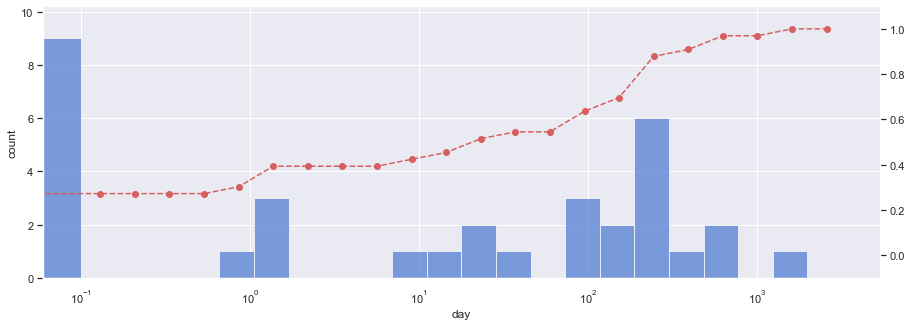

In [233]:
# % matplotlib inline

dt = df_same_commiter["delete_terms_day"]
xlabel = "day"
logmax = 3.5
bin_num = int((logmax+1)*10//2) if (logmax+1)*10 % 2 == 0 else int((logmax+1)*10//2) + 1

# seabornのスタイルでプロット
sns.set(style="darkgrid", palette="muted", color_codes=True)

fig, ax1 = plt.subplots(figsize=(15, 5))

# ヒストグラムプロットとビン情報の取得
# e+00 ~ e+01 で５本
n, bins, patches = ax1.hist(dt, alpha=0.7, label='Frequency', bins=np.append(0, np.logspace(-1, logmax, bin_num, base=10)))

# 第2軸用値の算出
y2 = np.add.accumulate(n) / n.sum()
x2 = np.convolve(bins, np.ones(2) / 2, mode="same")[1:]

# 第2軸のプロット
ax2 = ax1.twinx()
lines = ax2.plot(x2, y2, ls='--', color='r', marker='o',
         label='Cumulative ratio')
ax2.grid(visible=False)

ax1.set(xlabel=xlabel, ylabel='count')

fig.axes[0].set_xscale('log')
fig.axes[0].set_ylim([0, 10.2])
fig.axes[1].set_ylim([-0.1, 1.1])

plt.show()

In [234]:
graph = pd.DataFrame([n])
graph.index = ["件数"]
graph.columns = bins[:-1]

graph.iloc[:, 5:]

,0.7,1.1,1.7,2.7,4.3,6.9,11.1,17.8,28.5,45.6,73.1,117.0,187.4,300.1,480.6,769.8,1232.8,1974.5
件数,1.0,3.0,0.0,0.0,0.0,1.0,1.0,2.0,1.0,0.0,3.0,2.0,6.0,1.0,2.0,0.0,1.0,0.0


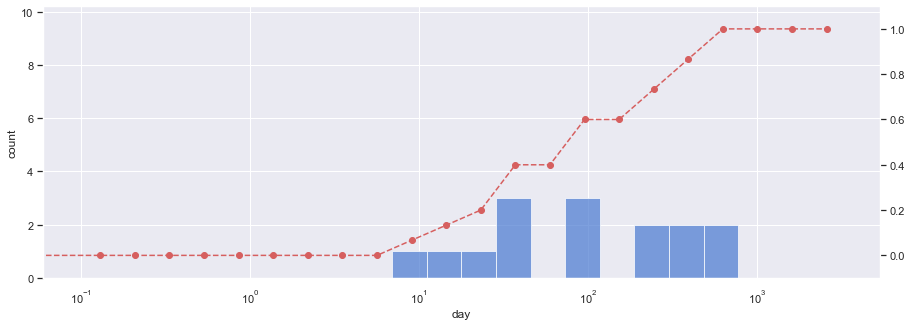

In [235]:
# % matplotlib inline

dt = df_different_commiter["delete_terms_day"]
xlabel = "day"
logmax = 3.5
bin_num = int((logmax+1)*10//2) if (logmax+1)*10 % 2 == 0 else int((logmax+1)*10//2) + 1

# seabornのスタイルでプロット
sns.set(style="darkgrid", palette="muted", color_codes=True)

fig, ax1 = plt.subplots(figsize=(15, 5))

# ヒストグラムプロットとビン情報の取得
# e+00 ~ e+01 で５本
n, bins, patches = ax1.hist(dt, alpha=0.7, label='Frequency', bins=np.append(0, np.logspace(-1, logmax, bin_num, base=10)))

# 第2軸用値の算出
y2 = np.add.accumulate(n) / n.sum()
x2 = np.convolve(bins, np.ones(2) / 2, mode="same")[1:]

# 第2軸のプロット
ax2 = ax1.twinx()
lines = ax2.plot(x2, y2, ls='--', color='r', marker='o',
         label='Cumulative ratio')
ax2.grid(visible=False)

ax1.set(xlabel=xlabel, ylabel='count')

fig.axes[0].set_xscale('log')
fig.axes[0].set_ylim([0, 10.2])
fig.axes[1].set_ylim([-0.1, 1.1])

plt.show()

In [236]:
graph = pd.DataFrame([n])
graph.index = ["件数"]
graph.columns = bins[:-1]

graph.iloc[:, 5:]

,0.7,1.1,1.7,2.7,4.3,6.9,11.1,17.8,28.5,45.6,73.1,117.0,187.4,300.1,480.6,769.8,1232.8,1974.5
件数,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,0.0,3.0,0.0,2.0,2.0,2.0,0.0,0.0,0.0
